<a href="https://colab.research.google.com/github/ztokar/PowerBI/blob/main/Facebook_Prophet_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [ ]:
#libraries
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [ ]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
future_df = pd.read_csv('future.csv')
future_df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2021,NaN,0,0,0,5.00,154.221
1,1/2/2021,NaN,0,0,0,11.11,264.805
2,1/3/2021,NaN,0,0,0,3.89,115.499
3,1/4/2021,NaN,0,0,0,6.67,124.650
4,1/5/2021,NaN,0,0,0,5.56,77.968


In [ ]:
#merge both datasets
df = pd.concat([df, future_df])
df = df.reset_index(drop = True)
df.tail()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
2218,1/27/2021,NaN,0,0,0,3.33,39.664
2219,1/28/2021,NaN,0,0,0,1.67,195.314
2220,1/29/2021,NaN,0,0,0,-2.78,235.894
2221,1/30/2021,NaN,0,0,0,1.11,152.752
2222,1/31/2021,NaN,0,0,0,4.44,158.620


In [ ]:
#Rename variable
df = df.rename(columns = {'Demand': 'y',
                          'Date': 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [ ]:
#Date variable
df.ds = pd.to_datetime(df.ds,
                       format = "%m/%d/%Y")
df.ds

0      2015-01-01
1      2015-01-02
2      2015-01-03
3      2015-01-04
4      2015-01-05
          ...    
2218   2021-01-27
2219   2021-01-28
2220   2021-01-29
2221   2021-01-30
2222   2021-01-31
Name: ds, Length: 2223, dtype: datetime64[ns]

#Holidays

In [ ]:
#Easter
dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': dates,
                       'lower_window': -5,
                       'upper_window': 2})

In [ ]:
#Thanksgiving
dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': dates,
                             'lower_window': -3,
                             'upper_window': 6})
thanksgiving

,holiday,ds,lower_window,upper_window
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6
1792,thanksgiving,2019-11-28,-3,6
2156,thanksgiving,2020-11-26,-3,6


In [ ]:
#Combining events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2
329,thanksgiving,2015-11-26,-3,6
693,thanksgiving,2016-11-24,-3,6
1057,thanksgiving,2017-11-23,-3,6
1421,thanksgiving,2018-11-22,-3,6


In [ ]:
#removing the holiday columns
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head(0)

,ds,y,Christmas,Temperature,Marketing


#Facebook Prophet model

In [ ]:
#Split the data
training = df.iloc[:-31,:]
future_df = df.iloc[-31:,:]

In [ ]:
#Fetch the parameters
parameters = pd.read_csv("Forecasting Product/best_params_prophet.csv",
                         index_col = 0)
parameters

,0
changepoint_prior_scale,0.005
holidays_prior_scale,5
seasonality_mode,additive
seasonality_prior_scale,1
rmse,48.06303866123096


In [ ]:
#Extract the values
changepoint_prior_scale = float(parameters.loc["changepoint_prior_scale"][0])
holidays_prior_scale = float(parameters.loc["holidays_prior_scale"][0])
seasonality_prior_scale = float(parameters.loc["seasonality_prior_scale"][0])
seasonality_mode = parameters.loc["seasonality_mode"][0]

In [ ]:
#FB model
m = Prophet(holidays = holidays,
            seasonality_mode = seasonality_mode,
            seasonality_prior_scale = seasonality_prior_scale,
            holidays_prior_scale = holidays_prior_scale,
            changepoint_prior_scale = changepoint_prior_scale)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.add_regressor('Marketing')
m.fit(training)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


#Forecasting

In [ ]:
#make a future dataframe
future = m.make_future_dataframe(periods = len(future_df),
                                 freq = "D") #W for weekly or M for monthly
future = pd.concat([future, df.iloc[:,2:]], axis = 1)
future.head()

,ds,Christmas,Temperature,Marketing
0,2015-01-01,0,3.68,41.305
1,2015-01-02,0,4.73,131.574
2,2015-01-03,0,7.23,162.700
3,2015-01-04,0,10.96,160.281
4,2015-01-05,0,6.92,51.077


In [ ]:
#Forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Marketing,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01,586.881290,606.255852,749.639310,586.881290,586.881290,0.0,0.0,0.0,-4.541945,...,-3.971478,-3.971478,-3.971478,88.105744,88.105744,88.105744,0.0,0.0,0.0,679.196682
1,2015-01-02,587.023828,523.787244,666.165184,587.023828,587.023828,0.0,0.0,0.0,0.260592,...,-89.357482,-89.357482,-89.357482,86.925146,86.925146,86.925146,0.0,0.0,0.0,596.396330
2,2015-01-03,587.166366,636.428523,783.111803,587.166366,587.166366,0.0,0.0,0.0,1.916573,...,25.173949,25.173949,25.173949,85.907458,85.907458,85.907458,0.0,0.0,0.0,708.901864
3,2015-01-04,587.308905,553.206303,692.597813,587.308905,587.308905,0.0,0.0,0.0,1.787876,...,-55.666143,-55.666143,-55.666143,85.069288,85.069288,85.069288,0.0,0.0,0.0,623.049805
4,2015-01-05,587.451443,683.218647,821.530192,587.451443,587.451443,0.0,0.0,0.0,-4.022050,...,74.200876,74.200876,74.200876,84.421776,84.421776,84.421776,0.0,0.0,0.0,751.137597


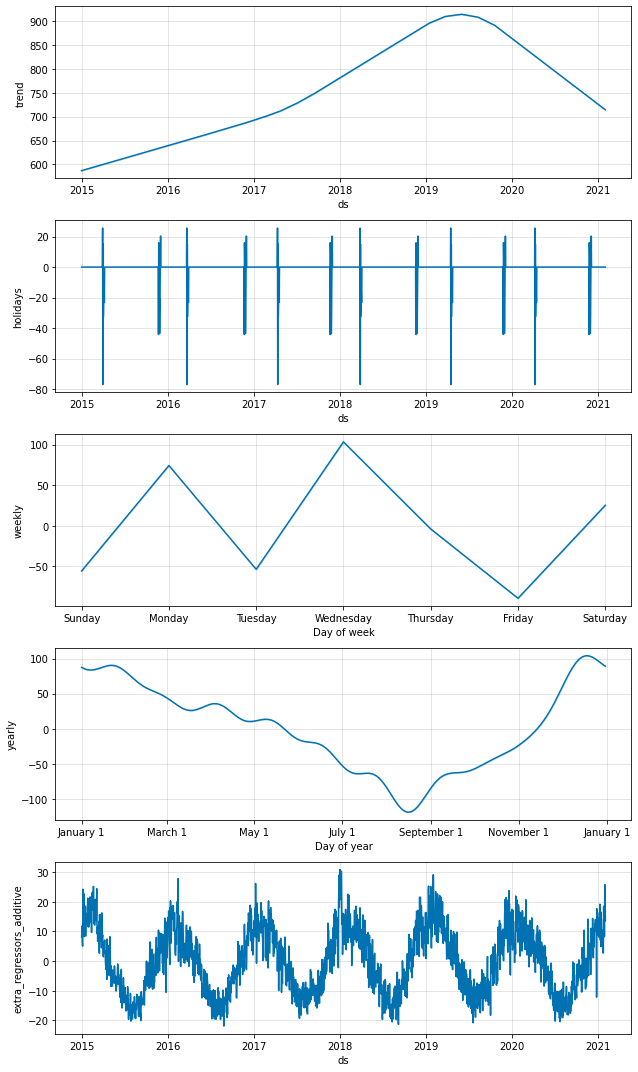

In [ ]:
#Plotting
m.plot_components(forecast);

In [ ]:
#extract the predictions
predictions_prophet = forecast.yhat[-len(future_df):].rename("prophet")
predictions_prophet.index = future_df["ds"]
predictions_prophet

In [ ]:
#export
predictions_prophet.to_csv("Forecasting Product/Ensemble/predictions_prophet.csv")